In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)

from keras.models import *
from keras.layers import *
from keras.optimizers import *

from keras.callbacks import ModelCheckpoint

#!pip install focal_loss
from focal_loss import BinaryFocalLoss

# Data preprocessing

In [2]:
im = "data/train/image/108.jpg"
img_mask = "data/train/label/108.jpg"
img_size = 256

img = cv2.imread(im)
img = cv2.resize(img,(img_size,img_size))
img_m = cv2.imread(img_mask)
img_m = cv2.resize(img_m,(img_size,img_size))
total_img = cv2.hconcat([img,img_m])
cv2.imshow("image",total_img)
cv2.waitKey(0) ##//(n)--->>n millisecs 0---->>>for infinite time till crossed
cv2.destroyAllWindows()


img_ma = cv2.imread(img_mask,cv2.IMREAD_GRAYSCALE)
img_mask = cv2.resize(img_ma,(img_size,img_size))
img_mask = np.reshape(img_mask, (img_size,img_size, -1)) 
print(img.shape, img_mask.shape)

(256, 256, 3) (256, 256, 1)


In [3]:
# ## generator for input values
# batch_size = 32
# data_size = 750
# img_size = 512
# dataset_path = os.path.join(os.getcwd(),"data/image")
# output_path = os.path.join(os.getcwd(),"data/label")
# step_ep=data_size//batch_size

# def generator():
#     while True:
#         train_dataset = []
#         output_dataset = []
#         i = 0
#         for file_name in os.listdir(dataset_path):
#             img = cv2.imread(os.path.join(dataset_path,file_name))
#             img_mask = cv2.imread(os.path.join(output_path,file_name))
            
#             img = cv2.resize(img, (img_size,img_size))
            
#             img_mask = cv2.resize(img_mask,(img_size,img_size))
#             img_mask = np.reshape(img_mask, (img_size,img_size, -1)) 
            
#             train_dataset.append(img)
#             output_dataset.append(img_mask)
            
#             i = i+1
#             if(i%batch_size == 0):
#                 X_train = np.array(train_dataset)/255.0
#                 Y_train = np.array(output_dataset)/255.0
#                 train_dataset = []
#                 output_dataset = []
#                 #print(yt[i-64:i].shape)
#                 yield X_train,Y_train
#         if(i%batch_size):
#             X_train = np.array(train_dataset)/255.0
#             Y_train = np.array(output_dataset)/255.0
#             yield X_train,Y_train

In [3]:
dataset_path = os.path.join(os.getcwd(),'data/train/image')

IMG_SHAPE = (256,256)

# Resize each image and convert the 0-255 ranged RGB values to 0-1 range.
def load_images_x(files, img_shape):
    cnt = len(files)
    x = np.zeros((cnt,)+img_shape+(3,),dtype=np.float32)
    i = 0
    for file in files:
        img = cv2.imread(file)
        img = cv2.resize(img, img_shape)
        img = img/255.0
        x[i,:,:,:] = img
        i+=1
    return x

df_train = os.listdir(dataset_path)
images_x = [os.path.join(dataset_path,w) for w in df_train]

x = load_images_x(images_x, IMG_SHAPE)
print(x.shape)

(750, 256, 256, 3)


In [4]:
output_path = os.path.join(os.getcwd(),'data/train/label')

IMG_SHAPE = (256,256)
img_size = 256
def load_images_y(files, img_shape):
    cnt = len(files)
    x = np.zeros((cnt,)+img_shape+(1,),dtype=np.float32)
    i = 0
    for file in files:
        img = cv2.imread(file,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img,img_shape)
        img = np.reshape(img, (img_size,img_size, -1))
        img = img/255.0
        x[i,:,:,:] = img
        i+=1
    return x

df_output = os.listdir(output_path)
# Load images
images_y = [os.path.join(output_path,q) for q in df_output]
y = load_images_y(images_y, IMG_SHAPE)
print(y.shape)

(750, 256, 256, 1)


In [5]:
x_dataset = tf.data.Dataset.from_tensor_slices(tf.constant(x, dtype=tf.float32))
y_dataset = tf.data.Dataset.from_tensor_slices(tf.constant(y, dtype=tf.float32))

# Combine 'x' and 'y' datasets into a single dataset
dataset = tf.data.Dataset.zip((x_dataset, y_dataset))

# Shuffle and batch the dataset
BATCH_SIZE = 2
number_of_samples = 750

In [6]:
# Define the size of the validation set (e.g., 20% of the total samples)
validation_set_size = 0.1

# Determine the total number of samples in the dataset
total_samples = 750

# Calculate the number of samples to use for validation
num_validation_samples = int(total_samples * validation_set_size)

# Shuffle the dataset
dataset = dataset.shuffle(buffer_size=total_samples)

# Split the dataset into training and validation sets
train_dataset = dataset.skip(num_validation_samples)
validation_dataset = dataset.take(num_validation_samples)

# Batch the datasets
BATCH_SIZE = 2
train_dataset = train_dataset.batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)

# MODEL

In [18]:
# img_rows = 512
# img_cols = 512

# inputs = Input((img_rows, img_cols, 3))

# conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
# conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
# pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

# conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
# conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
# pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

# conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
# conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
# pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)


# conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
# conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
# drop4 = Dropout(0.5)(conv4)
# pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

# conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
# conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
# drop5 = Dropout(0.5)(conv5)

# up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
#     UpSampling2D(size=(2, 2))(drop5))
# merge6 = concatenate([drop4, up6],axis=3)

# conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
# conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
# up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
#     UpSampling2D(size=(2, 2))(conv6))
# merge7 = concatenate([conv3, up7],axis=3)

# conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
# conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
# up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
#     UpSampling2D(size=(2, 2))(conv7))

# merge8 = concatenate([conv2, up8],axis=3)
# conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
# conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

# up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
#     UpSampling2D(size=(2, 2))(conv8))

# merge9 = concatenate([conv1, up9], axis=3)
# conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
# conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
# conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

# conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
# model = Model(inputs, conv10)

# model.summary()

In [7]:
def unet_model_small(input_shape=(256, 256, 3)):
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up4 = UpSampling2D(size=(2, 2))(conv3)
    up4 = Conv2D(128, 2, activation='relu', padding='same')(up4)
    merge4 = Concatenate(axis=3)([conv2, up4])
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(merge4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = Conv2D(64, 2, activation='relu', padding='same')(up5)
    merge5 = Concatenate(axis=3)([conv1, up5])
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(merge5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv5)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

# Create the model
model = unet_model_small(input_shape=(256, 256, 3))

# Display model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [9]:
data_folder = os.path.join(os.getcwd(),'weights')
checkpoint_path = os.path.join(data_folder, 'model_weights_{epoch:02d}.h5')
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_loss', save_weights_only=True, save_freq=5)
early_stopping_patience = 5
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stopping_patience, mode='min', verbose=1)

callbacks = [early_stopping]

In [10]:

model.compile(optimizer=Adam(learning_rate=1e-4),
            loss=BinaryFocalLoss(gamma=2), metrics=['accuracy',
            tf.keras.metrics.MeanIoU(num_classes=2)])

In [18]:
# history = model.fit(dataset, epochs=100, steps_per_epoch=32,
#                 verbose = 1, callbacks=[model_checkpoint])

history = model.fit(train_dataset, validation_data=validation_dataset, 
                    epochs=5, callbacks=callbacks)

Epoch 1/5
338/338 [==============================] - 1948s 6s/step - loss: 0.0459 - accuracy: 0.8397 - mean_io_u: 0.4962 - val_loss: 0.0439 - val_accuracy: 0.8362 - val_mean_io_u: 0.4961
Epoch 2/5
338/338 [==============================] - 1956s 6s/step - loss: 0.0446 - accuracy: 0.8402 - mean_io_u: 0.4962 - val_loss: 0.0441 - val_accuracy: 0.8466 - val_mean_io_u: 0.4960
Epoch 3/5
338/338 [==============================] - 1957s 6s/step - loss: 0.0439 - accuracy: 0.8410 - mean_io_u: 0.4961 - val_loss: 0.0407 - val_accuracy: 0.8421 - val_mean_io_u: 0.4962
Epoch 4/5
338/338 [==============================] - 1881s 6s/step - loss: 0.0425 - accuracy: 0.8412 - mean_io_u: 0.4961 - val_loss: 0.0443 - val_accuracy: 0.8332 - val_mean_io_u: 0.4962
Epoch 5/5
338/338 [==============================] - 1828s 5s/step - loss: 0.0421 - accuracy: 0.8415 - mean_io_u: 0.4962 - val_loss: 0.0386 - val_accuracy: 0.8496 - val_mean_io_u: 0.4963


In [19]:
model.save("models\\Unet_small_9")

INFO:tensorflow:Assets written to: models\Unet_small_9\assets


INFO:tensorflow:Assets written to: models\Unet_small_9\assets


In [11]:
LOAD_MODEL = 1
if LOAD_MODEL:
    model.load_weights("models\\Unet_small_9")

In [20]:
# for i in range(4):
#     pb_path = "models/Unet_small_" + str(i)
#     h5_path = "h5/Unet" + str(i) + ".h5"
#     model.load_weights(pb_path)
#     model.save(h5_path)
pb_path = "models/Unet_small_9"
h5_path = "h5/Unet9.h5"
# model.load_weights(pb_path)
model.save(h5_path)

In [21]:
im = "data/train/image/108.jpg"
img_mask = "data/train/label/108.jpg"

img = cv2.imread(im)
img = cv2.resize(img, (256, 256))
print(img.shape)

img_pred = []
img_pred.append(img)
img_pred = np.array(img_pred)
print(img_pred.shape)

img_pred = img_pred / 255.0

output = model.predict(img_pred)
output *= 255
output = np.clip(output, 0, 255)  # Ensure values are in the range [0, 255]
output = output.astype(np.uint8)  # Convert to uint8 data type
output = np.resize(output,(256,256,1))
print(output.shape,output.dtype)

img_m = cv2.imread(img_mask)
print(img_m.dtype)
# Display the original image and the predicted output side by side
total_img = cv2.hconcat([img, img_m])
cv2.imshow("Original Image and Mask", total_img)

cv2.imshow("Predicted Output", output)
cv2.waitKey(0)  # Press any key to close the displayed images
cv2.destroyAllWindows()

# img_ma = cv2.imread(img_mask,cv2.IMREAD_GRAYSCALE)
# img_mask = cv2.resize(img_ma,(img_size,img_size))
# img_mask = np.reshape(img_mask, (img_size,img_size, -1)) 
# print(img.shape, img_mask.shape)

(256, 256, 3)
(1, 256, 256, 3)
1/1 [==============================] - 1s 1s/step
(256, 256, 1) uint8
uint8


In [24]:
arr = np.random.randint(250, size=20)

X_in = "data/test/image/"
X_ma = "data/test/label/"

X_pred = []
X_mask = []

Y_pred = []

for i in arr:
    X_i = X_in+str(i)+".jpg"
    X_m = X_ma +str(i)+".jpg"
    img = cv2.imread(X_i)
    img_mask = cv2.imread(X_m)
    img = cv2.resize(img, (256, 256))
    
    X_pred.append(img)
    X_mask.append(img_mask)
    
img_pred = X_pred
img_pred = np.array(X_pred)
img_pred = img_pred / 255.0

output = model.predict(img_pred)
output *= 255
output = np.clip(output, 0, 255)  # Ensure values are in the range [0, 255]
output = output.astype(np.uint8)  # Convert to uint8 data type
#output = np.resize(output,(20,256,256,1))
print(output.shape,output.dtype)

1/1 [==============================] - 31s 31s/step
(20, 256, 256, 1) uint8


Reference for thresholding :  
https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html

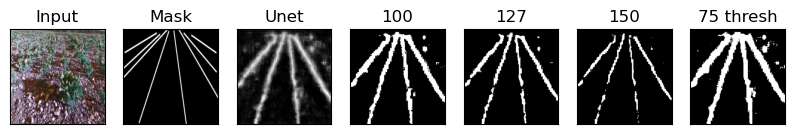

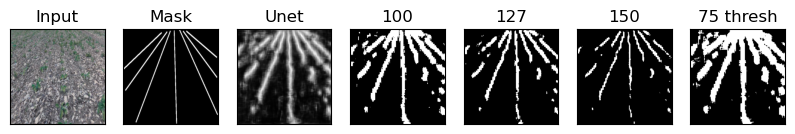

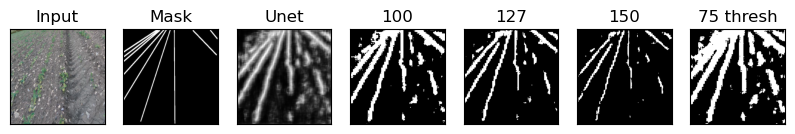

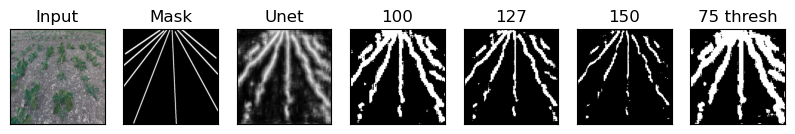

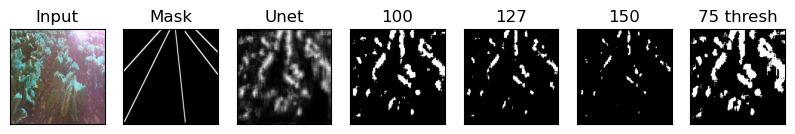

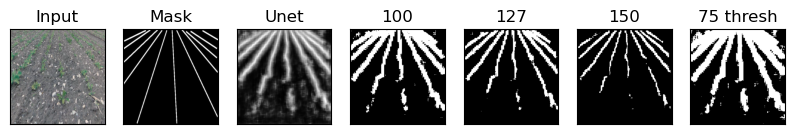

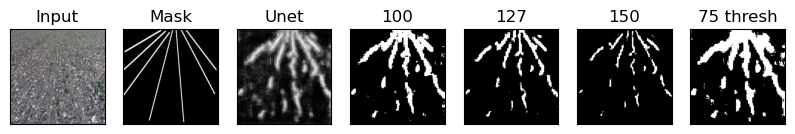

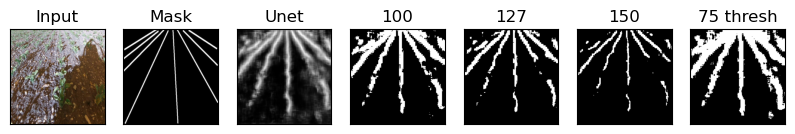

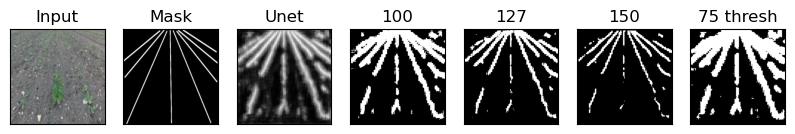

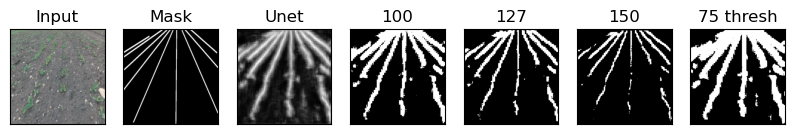

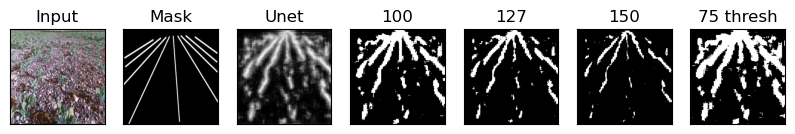

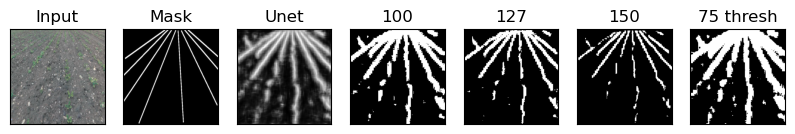

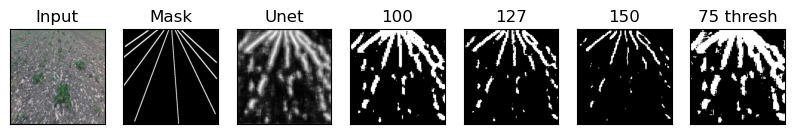

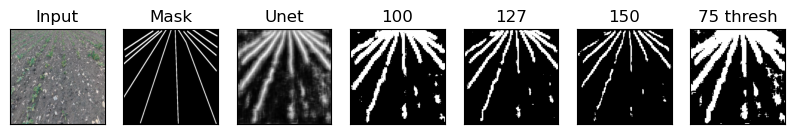

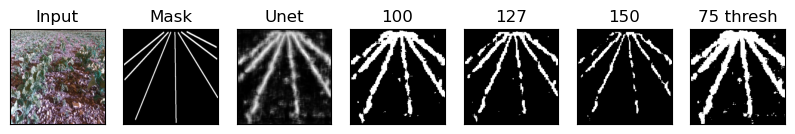

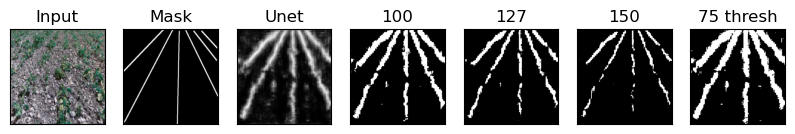

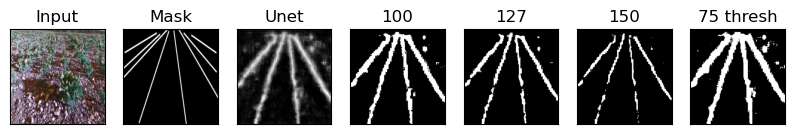

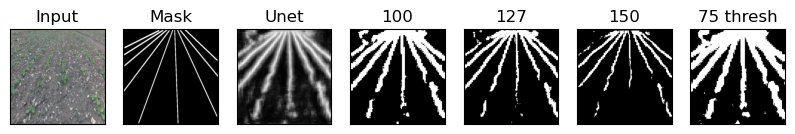

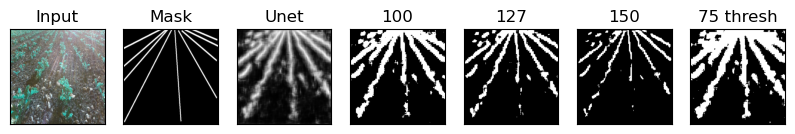

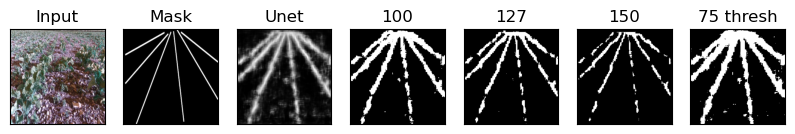

In [25]:
for i in range(20):
    k = 7
    ret,thresh0 = cv2.threshold(output[i],75,255,cv2.THRESH_BINARY)
    ret,thresh1 = cv2.threshold(output[i],100,255,cv2.THRESH_BINARY)
    ret,thresh2 = cv2.threshold(output[i],127,255,cv2.THRESH_BINARY)
    ret,thresh3 = cv2.threshold(output[i],150,255,cv2.THRESH_BINARY)
    
    fig, ax = plt.subplots(1, k, figsize=(10,10))
    plt.subplot(1,k,1),plt.imshow(X_pred[i])
    plt.xticks([]),plt.yticks([])
    plt.title("Input")
    
    plt.subplot(1,k,2),plt.imshow(X_mask[i])
    plt.xticks([]),plt.yticks([])
    plt.title("Mask")
    
    plt.subplot(1,k,3),plt.imshow(output[i],'gray')
    plt.xticks([]),plt.yticks([])
    plt.title("Unet")
    
    plt.subplot(1,k,4),plt.imshow(thresh1,'gray')
    plt.xticks([]),plt.yticks([])
    plt.title("100")
    
    plt.subplot(1,k,5),plt.imshow(thresh2,'gray')
    plt.xticks([]),plt.yticks([])
    plt.title("127")
    
    plt.subplot(1,k,6),plt.imshow(thresh3,'gray')
    plt.xticks([]),plt.yticks([])
    plt.title("150")
    
    plt.subplot(1,k,7),plt.imshow(thresh0,'gray')
    plt.xticks([]),plt.yticks([])
    plt.title("75 thresh")
    plt.show()

# Comparing 4 Unet models

In [26]:
arr = np.random.randint(250, size=20)

X_in = "data/test/image/"
X_ma = "data/test/label/"

X_pred = []
X_mask = []

Y_pred = []

for i in arr:
    X_i = X_in+str(i)+".jpg"
    X_m = X_ma +str(i)+".jpg"
    img = cv2.imread(X_i)
    img_mask = cv2.imread(X_m)
    img = cv2.resize(img, (256, 256))
    
    X_pred.append(img)
    X_mask.append(img_mask)
    
img_pred = X_pred
img_pred = np.array(X_pred)
img_pred = img_pred / 255.0

output = [None]*10
for i in range(10):
    unet_mod = "models\\Unet_small_"+str(i)
    model.load_weights(unet_mod)
    output[i] = model.predict(img_pred)
    output[i] *= 255
    output[i] = np.clip(output[i], 0, 255)  # Ensure values are in the range [0, 255]
    output[i] = output[i].astype(np.uint8)  # Convert to uint8 data type
    #output = np.resize(output,(20,256,256,1))
    print(output[i].shape,output[i].dtype)

1/1 [==============================] - 20s 20s/step
(20, 256, 256, 1) uint8
1/1 [==============================] - 10s 10s/step
(20, 256, 256, 1) uint8
1/1 [==============================] - 10s 10s/step
(20, 256, 256, 1) uint8
1/1 [==============================] - 9s 9s/step
(20, 256, 256, 1) uint8
1/1 [==============================] - 10s 10s/step
(20, 256, 256, 1) uint8
1/1 [==============================] - 10s 10s/step
(20, 256, 256, 1) uint8
1/1 [==============================] - 10s 10s/step
(20, 256, 256, 1) uint8
1/1 [==============================] - 10s 10s/step
(20, 256, 256, 1) uint8
1/1 [==============================] - 10s 10s/step
(20, 256, 256, 1) uint8
1/1 [==============================] - 11s 11s/step
(20, 256, 256, 1) uint8


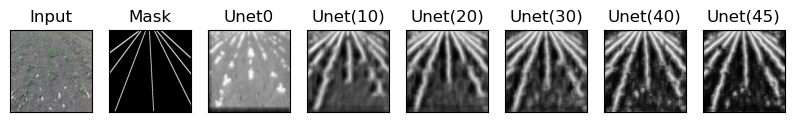

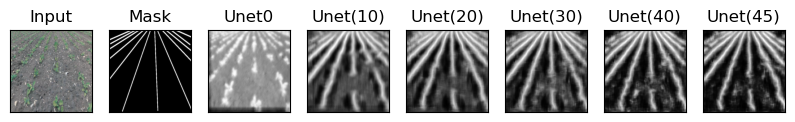

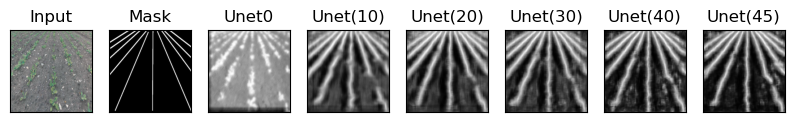

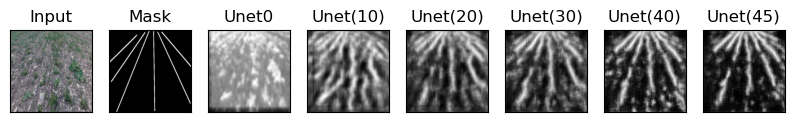

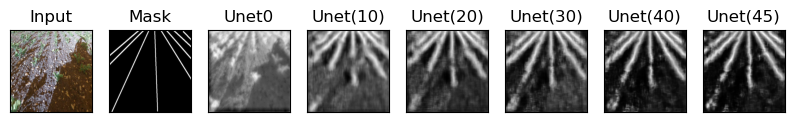

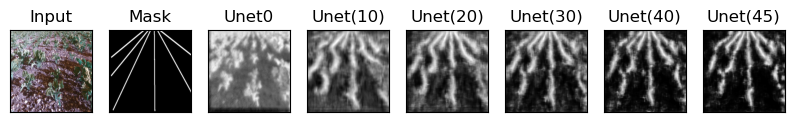

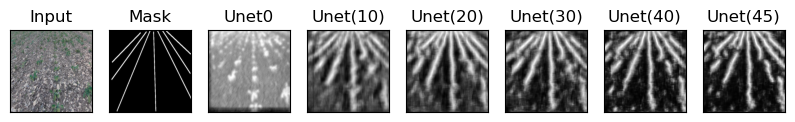

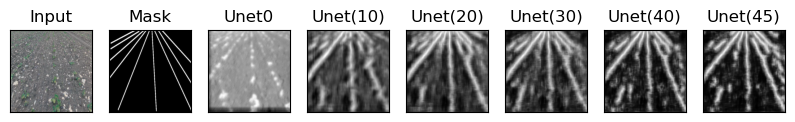

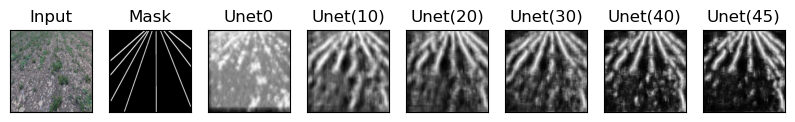

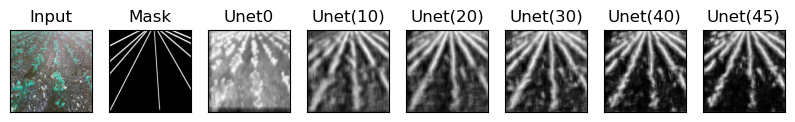

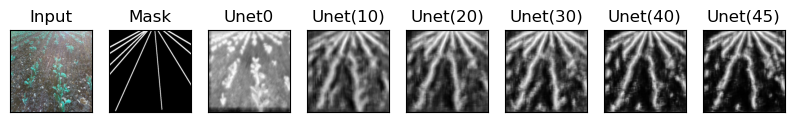

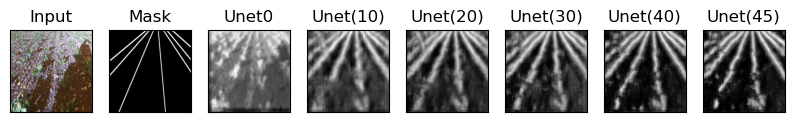

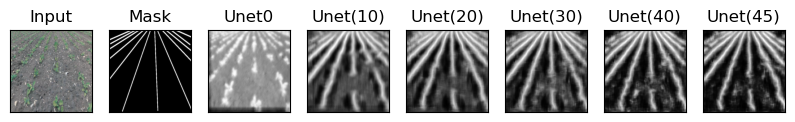

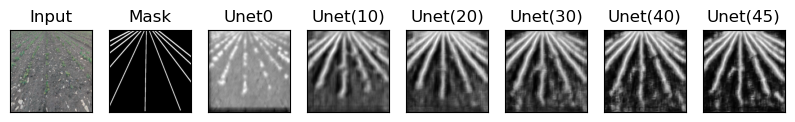

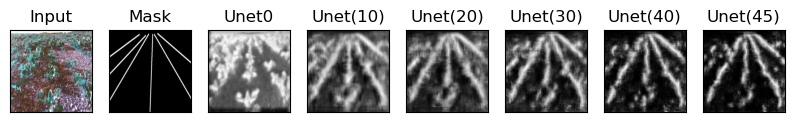

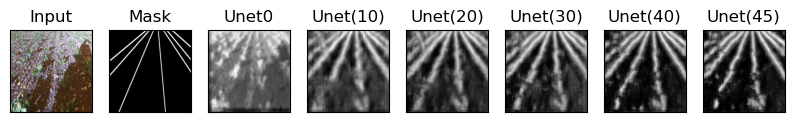

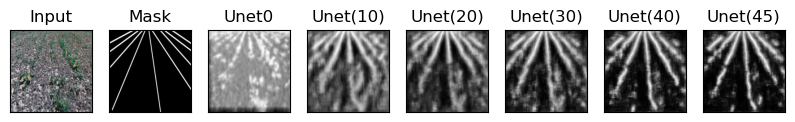

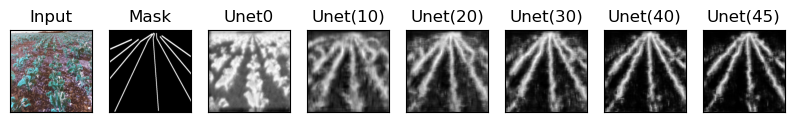

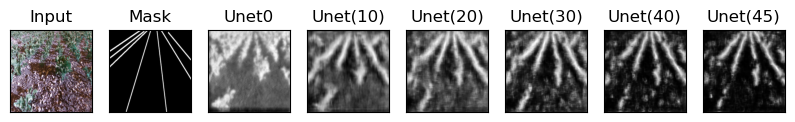

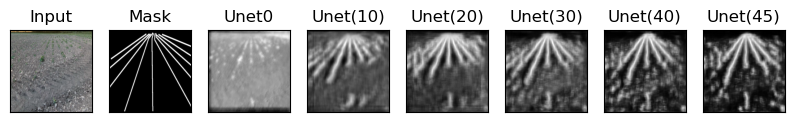

In [28]:
for i in range(20):
    k = 8
    fig, ax = plt.subplots(1, k, figsize=(10,10))
    plt.subplot(1,k,1),plt.imshow(X_pred[i])
    plt.xticks([]),plt.yticks([])
    plt.title("Input")
    
    plt.subplot(1,k,2),plt.imshow(X_mask[i])
    plt.xticks([]),plt.yticks([])
    plt.title("Mask")
    
    plt.subplot(1,k,3),plt.imshow(output[0][i],'gray')
    plt.xticks([]),plt.yticks([])
    plt.title("Unet0")
    
    plt.subplot(1,k,4),plt.imshow(output[2][i],'gray')
    plt.xticks([]),plt.yticks([])
    plt.title("Unet(10)")
    
    plt.subplot(1,k,5),plt.imshow(output[4][i],'gray')
    plt.xticks([]),plt.yticks([])
    plt.title("Unet(20)")
    
    plt.subplot(1,k,6),plt.imshow(output[6][i],'gray')
    plt.xticks([]),plt.yticks([])
    plt.title("Unet(30)")
    
    plt.subplot(1,k,7),plt.imshow(output[8][i],'gray')
    plt.xticks([]),plt.yticks([])
    plt.title("Unet(40)")
    
    plt.subplot(1,k,8),plt.imshow(output[9][i],'gray')
    plt.xticks([]),plt.yticks([])
    plt.title("Unet(45)")
    
    plt.show()